# 1. CCS Faciltiy emissions analysis 

Here are the point-source facilities emissions where amine-based CCS technology is applied. The case presented in here is over the Louisanna State. The data in the below presents the NEI2020 emissions (as "_old") as well as modified emissions by the CCS technology (without "_old") for major air pollutants. 

In [1]:
import geopandas as gpd

# read base and sens emission scenarios
gdf_CS_emis = gpd.read_file('/Users/yunhalee/Documents/LOCAETA/CS_emissions/Colorado_CCS_combined_NEI_point_oilgas_ptegu_ptnonimps.shp')

# Reset index to ensure proper comparison
gdf_CS_emis.reset_index(drop=True, inplace=True)

# def subset_data(final_df, state_fips=None):
#     if state_fips:
#         # Match the first two digits of FIPS with State FIPS code
#         return final_df[final_df['FIPS'].astype(str).str[:2] == str(state_fips)]
#     return final_df

# # Dictionary to loop over
# regions = {"LA": '22'} #, "Nation": None}

# final_df = gpd.GeoDataFrame(gdf_CS_emis, geometry= "geometry")
# type(final_df)

# for region_name, state_fips in regions.items():
    
#     # Subset the DataFrame based on the chosen state or national
#     final_df_subset = subset_data(final_df, state_fips)

#     print(f"Processing data for: {region_name}")
    
def subset_pollutants_with_difference(df, pollutants):
    mask = False  # Initialize a mask to filter rows
    for pollutant in pollutants:
        col_current = pollutant
        col_old = f'{pollutant}_old'
        
        if col_current in df.columns and col_old in df.columns:
            # Check where the pollutant and its "_old" version differ
            mask |= (df[col_current] != df[col_old])

    # Subset the dataframe based on the mask
    return df[mask]

pollutants = ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']
subset_df = subset_pollutants_with_difference(gdf_CS_emis, pollutants)

subset_df.head()

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


,FIPS,SCC,VOC_old,NOx_old,NH3_old,SOx_old,PM2_5_old,height,diam,temp,velocity,EIS_ID,ghgrp_faci,frs_id,VOC,NOx,NH3,SOx,PM2_5,geometry
283,08123,20100201,16.3000,439.5,93.159,9.21,55.3695,53.34,4.57200,100.00000,28.6512,3551511,1001029.0,1.100225e+11,18.982226,316.440,349.189706,0.0921,2.563054,POINT (-663965.526 55833.920)
284,08123,20100201,16.3000,439.5,93.159,9.21,55.3695,53.34,4.57200,100.00000,28.6512,3551511,1001029.0,1.100712e+11,18.982226,316.440,349.189706,0.0921,2.563054,POINT (-663965.526 55833.920)
1704,08001,20100201,2.2000,99.3,0.000,1.80,12.7001,22.86,5.54736,666.66667,25.6032,12818011,1000141.0,1.100314e+11,2.494518,71.496,28.113070,0.0180,0.587888,POINT (-652329.196 -711.107)
1705,08123,20100201,5.7767,146.7,0.000,7.70,19.3002,53.34,5.63880,89.44444,18.8976,12868211,1000271.0,1.100712e+11,7.612225,105.624,175.209220,0.0770,0.893406,POINT (-641913.733 36890.849)
1706,08123,20100201,5.7767,146.7,0.000,7.70,19.3002,53.34,5.63880,89.44444,18.8976,12868211,1000271.0,1.100178e+11,7.612225,105.624,175.209220,0.0770,0.893406,POINT (-641913.733 36890.849)


The cobenefits code, which process the air quality emissions based on the CCS technology, generates higher emissions of NOx and SOx for 1-2 facilities, which appears bug in the code. The dataframe below shows two facilities with higher SOx emission by CCS. 

In [2]:
# Find the case where SOx is higher than SOx_old
if 'SOx' in subset_df.columns and 'SOx_old' in subset_df.columns:
    filtered_SOx_df = subset_df[subset_df['SOx'] > subset_df['SOx_old']]

filtered_SOx_df.head()

,FIPS,SCC,VOC_old,NOx_old,NH3_old,SOx_old,PM2_5_old,height,diam,temp,velocity,EIS_ID,ghgrp_faci,frs_id,VOC,NOx,NH3,SOx,PM2_5,geometry


The dataframe below shows the facility with higher NOx emission by CCS. The incorrect emissions are very small (total 0.5 tons for NOx and 4 tons for SOx), and it is unlikely affect our overall results. Nevertheless, these emissions should be fixed from the cobenefits code in future. Otherwise, I need to manually remove these emissions. 

In [3]:
# Find the case where NOx is higher than NOx_old
if 'NOx' in subset_df.columns and 'NOx_old' in subset_df.columns:
    filtered_NOx_df = subset_df[subset_df['NOx'] > subset_df['NOx_old']]

filtered_NOx_df.head()

,FIPS,SCC,VOC_old,NOx_old,NH3_old,SOx_old,PM2_5_old,height,diam,temp,velocity,EIS_ID,ghgrp_faci,frs_id,VOC,NOx,NH3,SOx,PM2_5,geometry


In [4]:
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import os

# Function to plot the percent change of each pollutant and its "_old" version with a basemap
def plot_spatial_distribution_percent_change_with_basemap(gdf, output_dir):
    pollutants = ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']
    
    # Ensure the GeoDataFrame is in the correct CRS for basemaps (Web Mercator)
    gdf = gdf.to_crs(epsg=3857)

    for pollutant in pollutants:
        fig, ax = plt.subplots(figsize=(10, 6))

        col_current = f'{pollutant}'
        col_old = f'{pollutant}_old'

        # Ensure both the current and "_old" columns exist in the GeoDataFrame
        if col_current not in gdf.columns or col_old not in gdf.columns:
            print(f'Columns {col_current} or {col_old} do not exist in the data.')
            continue
        
        # Calculate the percent change, avoiding division by zero
        gdf['percent_change'] = ((gdf[col_current] - gdf[col_old]) / gdf[col_old].replace(0, float('nan'))) * 100

        # Plot the spatial distribution of the percent change
        vmin, vmax = -100, 100  # Fixed color scale from -50% to 50%

        if pollutant == 'NH3':
            vmin, vmax = -200, 200 

        gdf.plot(column='percent_change', cmap='coolwarm', vmin=vmin, vmax=vmax, legend=False, edgecolor='black', 
                 ax=ax, markersize=30, alpha=0.95)  # Increase marker size and reduce transparency

        # Add a basemap (using OpenStreetMap)
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

        ax.set_title(f'Percent Change in {pollutant} emissions by amine-based CCS')

        # Calculate the total, max, and min percent change
        total_current = gdf[col_current].sum()
        total_old = gdf[col_old].sum()
        total_percent_change = ((total_current - total_old) / total_old) * 100
        max_percent_change = gdf['percent_change'].max()
        min_percent_change = gdf['percent_change'].min()

        # Display the total, max, and min percent changes on the plot
        ax.text(0.5, -0.15, f'Total Percent Change: {total_percent_change:.2f}%\nMax Percent Change: {max_percent_change:.2f}%\nMin Percent Change: {min_percent_change:.2f}%', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

        # Add a color bar for the pollutant
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
        sm._A = []
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position color bar to avoid overlap
        fig.colorbar(sm, cax=cbar_ax).set_label(f'{pollutant} Percent Change')

        # Adjust layout to prevent overlap
        plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)

        # Save the figure for each pollutant as a separate file
        plt.savefig(os.path.join(output_dir, f'{pollutant}_percent_change_with_basemap.png'), dpi=300, bbox_inches='tight')
        plt.close()  # Close the figure to avoid overlapping plots

# Example usage
output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/'
plot_spatial_distribution_percent_change_with_basemap(subset_df, output_dir)


Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


In [5]:
# Function to plot the percent change of each pollutant and its "_old" version with a basemap
def plot_spatial_distribution_relative_difference_with_basemap(gdf, output_dir):
    pollutants = ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']
    
    # Ensure the GeoDataFrame is in the correct CRS for basemaps (Web Mercator)
    gdf = gdf.to_crs(epsg=3857)

    for pollutant in pollutants:
        fig, ax = plt.subplots(figsize=(10, 6))

        col_current = f'{pollutant}'
        col_old = f'{pollutant}_old'

        # Ensure both the current and "_old" columns exist in the GeoDataFrame
        if col_current not in gdf.columns or col_old not in gdf.columns:
            print(f'Columns {col_current} or {col_old} do not exist in the data.')
            continue
        
        # Calculate the percent change, avoiding division by zero
        gdf['reverse_percent_change'] = ((gdf[col_old] - gdf[col_current]) / gdf[col_current].replace(0, float('nan'))) * 100

        # Plot the spatial distribution of the percent change
        vmin, vmax = -100, 100  # Fixed color scale from -50% to 50%

        if pollutant == 'NH3':
            vmin, vmax = -200, 200 

        gdf.plot(column='reverse_percent_change', cmap='coolwarm', vmin=vmin, vmax=vmax, legend=False, edgecolor='black', 
                 ax=ax, markersize=30, alpha=0.95)  # Increase marker size and reduce transparency

        # Add a basemap (using OpenStreetMap)
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

        ax.set_title(f'Relative Difference in {pollutant} NEI 2020 Emissions Compared to Amine-Based CCS Emissions')

        # Calculate the total, max, and min percent change
        total_current = gdf[col_current].sum()
        total_old = gdf[col_old].sum()
        total_percent_change = ((total_old - total_current) / total_current) * 100
        max_percent_change = gdf['reverse_percent_change'].max()
        min_percent_change = gdf['reverse_percent_change'].min()

        # Display the total, max, and min percent changes on the plot
        ax.text(0.5, -0.15, f'Total Relative Difference: {total_percent_change:.2f}%\nMax Relative Difference: {max_percent_change:.2f}%\nMin Relative Difference: {min_percent_change:.2f}%', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

        # Add a color bar for the pollutant
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
        sm._A = []
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position color bar to avoid overlap
        fig.colorbar(sm, cax=cbar_ax).set_label(f'{pollutant} Relative Difference')

        # Adjust layout to prevent overlap
        plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)

        # Save the figure for each pollutant as a separate file
        plt.savefig(os.path.join(output_dir, f'{pollutant}_Relative_Difference_with_basemap.png'), dpi=300, bbox_inches='tight')
        plt.close()  # Close the figure to avoid overlapping plots

# Example usage
output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/'
plot_spatial_distribution_relative_difference_with_basemap(subset_df, output_dir)

To spatial distribution of the emissions changes by amine-based CCS technology are presented here. It shows the percent changes computed using the difference between the emissions with CCS and the original NEI2020 emissions divided by the NEI2020 emissions. For Primary PM2.5, NOx and SOx, it shows negative percent changes because the CCS tech reduces their emissions. For VOC, the percent changes are only slightly positive. 
<table>
  <tr>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/PM2_5_percent_change_with_basemap.png" alt="PM2.5" width="400"/></td>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/VOC_percent_change_with_basemap.png" alt="VOC" width="400"/></td>
  </tr>
  <tr>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/NOx_percent_change_with_basemap.png" alt="NOx" width="400"/></td>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/SOx_percent_change_with_basemap.png" alt="SOx" width="400"/></td>
  </tr>
</table>

The amine-based CCS technology increases NH3 emissions significatly. Several point-source facilities with zero NH3 emissions in the NEI2020 emission inventory have positive NH3 emissions. Since the percent changes calculation used for other pollutants uses the NEI2020 emissions as dinominator, it drops out several facilities with zero NH3 emissions in the NEI2020 inventory. Thus, the percent change calculation used for NH3 is based on the emissions with CCS, instead of the NEI2020 emissions - it computes using the difference between the original NEI2020 emissions and the emissions with CCS, divided by the CCS emissions. The percent changes for other pollutants show how the CCS technology changes their emissions from the NEI2020 inventory while the one for NH3 shows how the NEI2020 inventory changes its emission from the CCS emissions. 
<td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/NH3_Relative_Difference_with_basemap.png" alt="NH3" width="800"/></td>

The changes in emissions by the CCS technology is also presented in barplot. It shows total emissions in tonnes by each county (FIPS code) for each pollutant. 

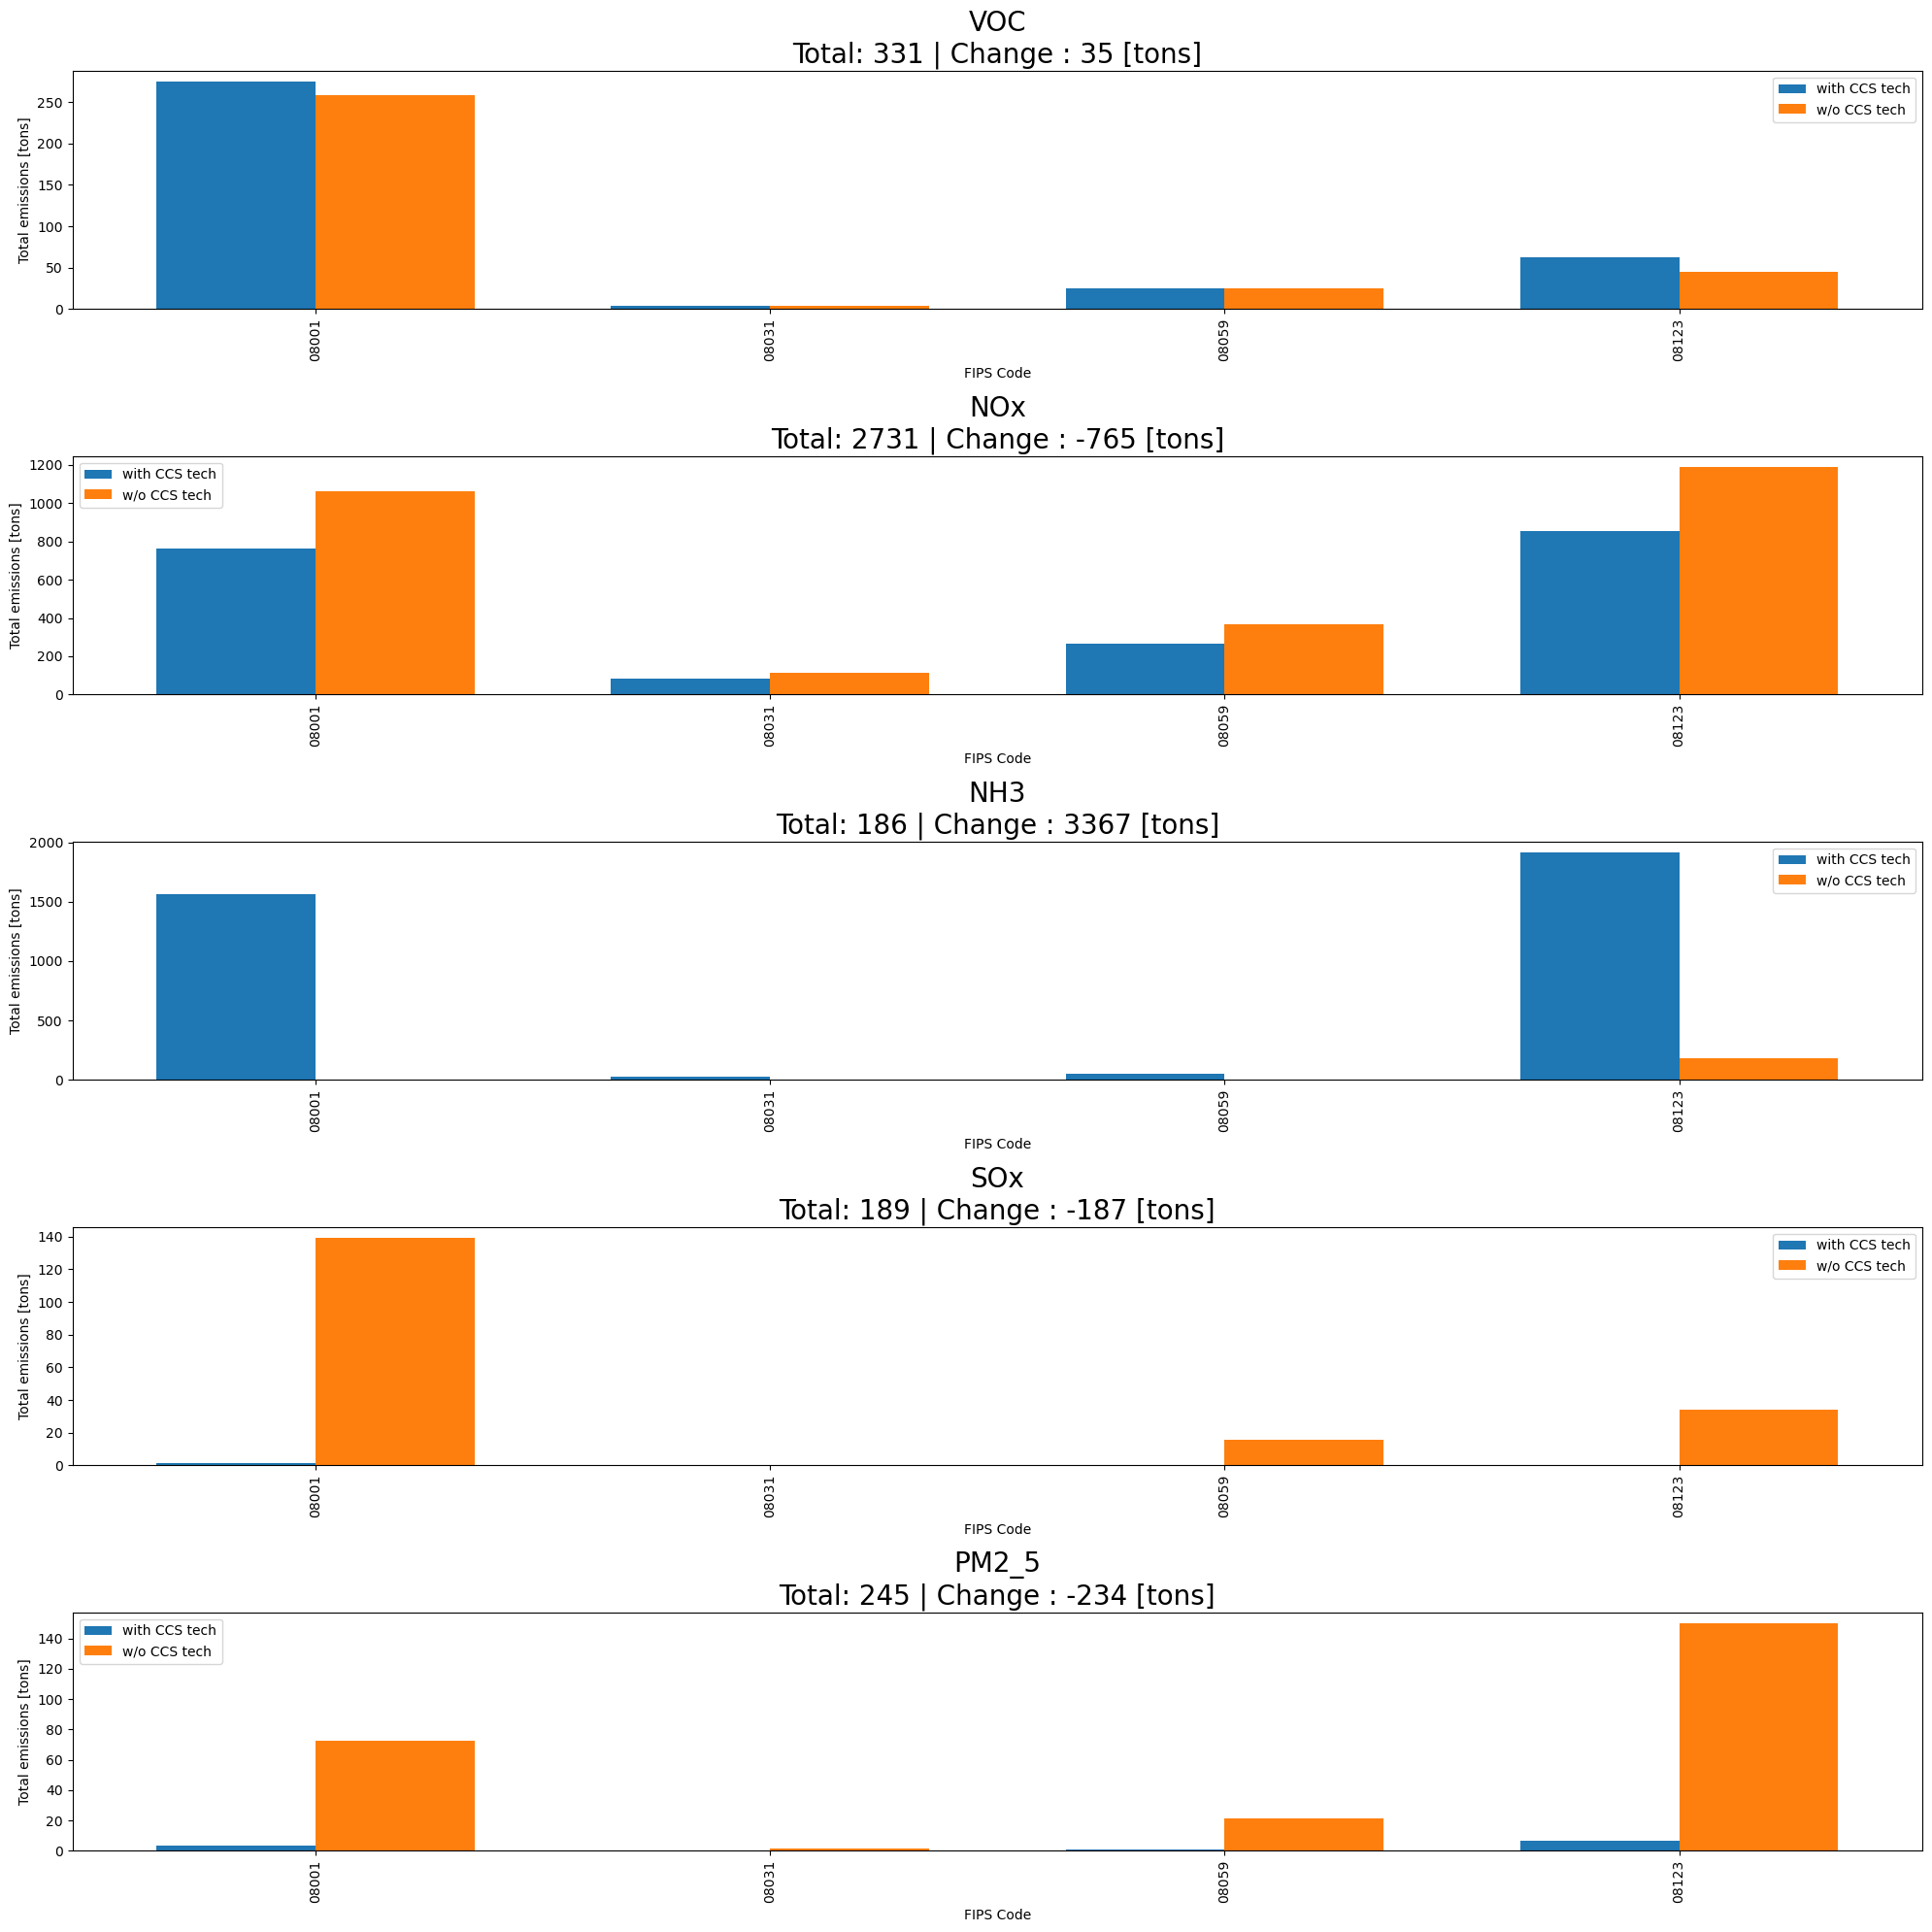

In [6]:
import numpy as np

# sum by FIPS
grouped_df = subset_df.drop(columns='geometry').groupby('FIPS').sum().reset_index()

pollutants = ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']
pollutants_old = [f'{pollutant}_old' for pollutant in pollutants]

# Calculate total sums for each pollutant
totals = {pollutant: subset_df[pollutant].sum() for pollutant in pollutants_old}
totals_CCS ={pollutant: subset_df[pollutant].sum() for pollutant in pollutants}

# Plotting
fig, axes = plt.subplots(nrows=len(pollutants), ncols=1, figsize=(20, 20) ) #, sharey=True)
bar_width = 0.35  # Width of the bars
for i, pollutant in enumerate(pollutants):
    ax = axes[i]
    indices = np.arange(len(grouped_df))
    # Plot CCS emissions
    ax.bar(indices, grouped_df[pollutant], bar_width, label=f'{pollutant}')
    
    # Plot NEI2020
    ax.bar(indices + bar_width, grouped_df[pollutants_old[i]], bar_width, label=f'{pollutants_old[i]}')
    
    total_original = totals[f'{pollutant}_old']
    total_new = totals_CCS[f'{pollutant}']
    ax.set_title(f'{pollutant}\nTotal: {total_original:.0f} | Change : {(total_new - total_original):.0f} [tons]', fontsize=20)
    ax.set_xlabel('FIPS Code')
    ax.set_ylabel('Total emissions [tons]')
    ax.set_xticks(indices + bar_width / 2)
    ax.set_xticklabels(grouped_df['FIPS'], rotation=90)
    ax.legend(["with CCS tech", "w/o CCS tech"])

plt.tight_layout()
plt.show()

In [8]:
from IPython.display import display, Markdown

markdown_text = f"The number of facilties applied with the amine-based CCS technology is **{len(subset_df['EIS_ID'].unique())}**, which is all located in the CO state. "
                 
for i, pollutant in enumerate(pollutants):
    total_original = totals[f'{pollutant}_old']
    change = totals_CCS[f'{pollutant}'] - total_original

    # Use Markdown to display the computed value
    markdown_text +=f"For {pollutant}, the total NEI2020 emissions are **{total_original:.0f}** in tons, and it is changed by **{change:.0f}** with amine-based CCS technology. "


# Display the entire paragraph in one go
display(Markdown(markdown_text))

The number of facilties applied with the amine-based CCS technology is **9**, which is all located in the CO state. For VOC, the total NEI2020 emissions are **331** in tons, and it is changed by **35** with amine-based CCS technology. For NOx, the total NEI2020 emissions are **2731** in tons, and it is changed by **-765** with amine-based CCS technology. For NH3, the total NEI2020 emissions are **186** in tons, and it is changed by **3367** with amine-based CCS technology. For SOx, the total NEI2020 emissions are **189** in tons, and it is changed by **-187** with amine-based CCS technology. For PM2_5, the total NEI2020 emissions are **245** in tons, and it is changed by **-234** with amine-based CCS technology. 

## 2. INMAP simulation results
